In [5]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [7]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers

#data_by_person 

rows_body_weight = [row for row in data[1:] if (row[8]) != '']  

#rows_body_weight

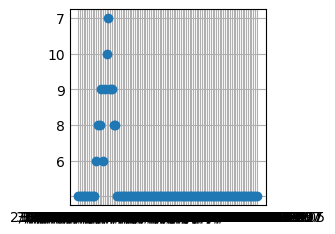

In [ ]:
# plot
x = [row[0] for row in rows_body_weight]
y = [row[7] for row in rows_body_weight]

plt.style.use('_mpl-gallery')

fig, ax = plt.subplots()

# size and color:
sizes = np.random.uniform(15, 80, len(x))
colors = np.random.uniform(15, 80, len(x))

#matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)[source]

ax.scatter(x, y)

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       #ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [ ]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

tab1

,2023-02-26 20:10:24.513000,Bench,straight,barbell,1,155,8,7,Unnamed: 8,Unnamed: 9,Steven Dimov,Unnamed: 11,155.1,6,1240,9670,44983
0,2023-02-26 20:12:48.526,Bench,straight,barbell,2.0,155,8.0,8.0,NaN,NaN,Steven Dimov,NaN,155,4.0,1240.0,9670.0,44983
1,2023-02-26 20:15:59.527,Bench,straight,barbell,3.0,155,8.0,9.0,NaN,NaN,Steven Dimov,NaN,155,6.0,1240.0,9670.0,44983
2,2023-02-26 20:19:36.136,Bench,straight,barbell,4.0,155,8.0,8.0,NaN,NaN,Steven Dimov,NaN,155,51.0,1240.0,9670.0,44983
3,2023-02-26 20:22:57.518,tricep pull,single arm,cable,1.0,25,3.0,8.0,NaN,NaN,Steven Dimov,NaN,NaN,NaN,75.0,9670.0,44983
4,2023-02-26 20:24:43.467,tricep pull,single arm,cable,2.0,20,6.0,7.0,NaN,NaN,Steven Dimov,NaN,NaN,NaN,120.0,9670.0,44983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
722,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
723,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
724,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
